# Diplomatura en ciencia de datos, aprendizaje automático y sus aplicaciones - Edición 2023 - FAMAF (UNC)

## Introducción al aprendizaje profundo

### Trabajo práctico entregable 2/2

- **Estudiantes:**
    - [Chevallier-Boutell, Ignacio José](https://www.linkedin.com/in/nachocheva/) (materia completa).
    - Gastelu, Gabriela (materia completa).
    - Spano, Marcelo (materia completa).

- **Docentes:**
    - Johanna Analiz Frau (Mercado Libre).
    - Nindiría Armenta Guerrero (fyo).

---

## Librerías

In [145]:
# Importando líbrerias
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

import torch
from torch.utils.data import TensorDataset, DataLoader, SubsetRandomSampler, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor, transforms
from torchvision.utils import make_grid

from tqdm.notebook import tqdm

# Para que todo sea reproducible
torch.manual_seed(1994)

import time

In [146]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Funciones útiles

### Preparación

In [147]:
def data_preparation(BATCH_SIZE, transform):

    # Download and load the training data
    trainval_set = datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)

    # 40000 para entrenamiento y 10000 para validación
    train_split = 40000
    validate_split = 10000

    train_set, val_set = random_split(trainval_set, [train_split, validate_split])

    train_loader = DataLoader(train_set, batch_size=BATCH_SIZE,
                                            shuffle=True, num_workers=2)

    val_loader = DataLoader(val_set, batch_size=BATCH_SIZE,
                                            shuffle=True, num_workers=2)

    # Download and load the test data
    test_set = datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
    test_loader = DataLoader(test_set, batch_size=BATCH_SIZE,
                                            shuffle=False, num_workers=2)

    return train_set, train_loader, val_set, val_loader, test_set, test_loader

### Entrenamiento y validación

In [148]:
def train_val(model, criterion, optimizer, train_loader, val_loader, num_epochs):
    print('>>> Running...')
    # Ciclo for para el número de épocas
    train_loss_history, train_acc_history, val_loss_history, val_acc_history = [], [], [], []
    all_labels, all_preds = [], []
    model = model.to(device=device)
    start = time.time()
    for epoch in range(1, num_epochs + 1):
        train_loss = 0.0
        train_acc = 0.0
        val_loss = 0.0
        val_acc = 0.0

        # Establecer el modelo en modo de entrenamiento
        model.train()
        y_true = []
        y_pred = []
        # Iterar sobre los datos de entrenamiento
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device, dtype=torch.long)
            optimizer.zero_grad()
            predicted_outputs = model(inputs)
            # Calcular la pérdida
            loss = criterion(predicted_outputs, labels)
            loss.backward()
            optimizer.step()
            # Acumular la pérdida y la precisión
            train_loss += loss.item()
            # La etiqueta con mayor valor será nuestra predicción
            _, predicted = torch.max(predicted_outputs , 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

        # Calcular la pérdida y precisión promedio del entrenamiento
        train_loss /= len(train_loader)
        train_loss_history.append(train_loss)
        train_acc = accuracy_score(y_true, y_pred)
        train_acc_history.append(train_acc)

        # set the model to evaluation mode
        model.eval()
        y_true = []
        y_pred = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device, dtype=torch.long)
                # Run the forward pass
                predicted_outputs = model(inputs)
                # Compute loss
                loss = criterion(predicted_outputs, labels)
                # Accumulate the average loss of the mini-batch
                val_loss += loss.item()
                # The label with the highest value will be our prediction
                _, predicted = torch.max(predicted_outputs , 1)
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())

        # calculate the average validation loss and accuracy
        val_loss /= len(val_loader)
        val_loss_history.append(val_loss)
        val_acc = accuracy_score(y_true, y_pred)
        val_acc_history.append(val_acc)
        all_labels.extend(y_true)
        all_preds.extend(y_pred)

        if (epoch % 10 == 0) and (epoch != num_epochs):
            print(f'Voy por la época {epoch}! :)')
            print(f'\t Train >> Loss: {train_loss:.4f} - Acc: {train_acc:.4f}')
            print(f'\t   Val >> Loss: {val_loss:.4f} - Acc: {val_acc:.4f}')
        elif epoch == num_epochs:
            WallTime = time.time() - start
            print(f'\tTerminé! :D')
            print(f'\t Train >> Loss: {train_loss:.4f} - Acc: {train_acc:.4f}')
            print(f'\t   Val >> Loss: {val_loss:.4f} - Acc: {val_acc:.4f}')
            print(f'<<< WallTime = {WallTime/60:.2f} min')

    modelo = model.__class__.__name__
    activacion = model.actfunc
    GD = optimizer.__class__.__name__
    LR = optimizer.param_groups[0]['lr']
    Walltime = f'{WallTime/60:.2f}'
    titulo = f'{modelo}_{activacion}_{GD}_LR-{LR}_Walltime-{Walltime}min'

    # Guardamos métricas
    Arr = np.array([train_loss_history, train_acc_history, val_loss_history, val_acc_history]).T
    df = pd.DataFrame(Arr, columns=['train_loss_history', 'train_acc_history', 'val_loss_history', 'val_acc_history'])
    df.to_csv(titulo+'_Metricas.csv', index=False)

    # Guardamos etiquetas
    Arr = np.array([all_labels, all_preds]).T
    df = pd.DataFrame(Arr, columns=['all_labels', 'all_preds'])
    df.to_csv(titulo+'_Etiquetas.csv', index=False)

    print(titulo)

### Gráficas

In [177]:
def plotting_confusion_matrix(path, CIFAR_CLASSES):
    Arr = pd.read_csv(path).to_numpy()

    # Plotting Confusion Matrix
    fig, axs = plt.subplots(1, 2, figsize = (14, 6))

    # Implementing visualization of Confusion Matrix
    c_m = confusion_matrix(Arr[:,0], Arr[:,1])
    c_m_normalized = confusion_matrix(Arr[:,0], Arr[:,1], normalize='true').round(3)

    ConfusionMatrixDisplay(c_m, display_labels=CIFAR_CLASSES).plot(cmap='Greys', xticks_rotation=25, ax=axs[0])
    ConfusionMatrixDisplay(c_m_normalized*100, display_labels=CIFAR_CLASSES).plot(cmap='Greys', xticks_rotation=25, ax=axs[1],)

    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    axs[0].set_title('Valores absolutos', fontsize=14)
    axs[1].set_title('Valores porcentuales', fontsize=14)

    titulo = path.split('_Etiquetas')[0]
    if len(titulo.split('Outputs/')) == 2:
        titulo = titulo.split('Outputs/')[1]
    plt.suptitle(titulo, fontsize=16)
    plt.show()

def plot_loss_and_accuracy(path):
    Arr = pd.read_csv(path).to_numpy()

    xAxis = [x+1 for x in range(Arr.shape[0])]
    xTicks = [(k+1)*10 for k in range(int(100/10))]

    fig, axs = plt.subplots(1, 2, figsize = (10, 4))

    # Plot the training and validation loss
    axs[0].plot(xAxis, Arr[:, 0], label='train loss')
    axs[0].plot(xAxis, Arr[:, 2], label='val loss')
    axs[0].grid()
    axs[0].set_xlabel('Épocas')
    axs[0].set_xticks(xTicks)
    axs[0].set_ylabel('Loss')
    axs[0].legend(loc='upper right')


    # Plot the training and validation accuracy
    axs[1].plot(xAxis, Arr[:, 1], label='train acc')
    axs[1].plot(xAxis, Arr[:, 3], label='val acc')
    axs[1].grid()
    axs[1].set_xlabel('Épocas')
    axs[1].set_xticks(xTicks)
    axs[1].set_ylabel('Acc')
    axs[1].legend(loc='lower right')

    titulo = path.split('_Metricas')[0]
    if len(titulo.split('Outputs/')) == 2:
        titulo = titulo.split('Outputs/')[1]

    plt.suptitle(titulo, fontsize=16)
    plt.show()

---
# Descripción, carga y preprocesamiento del dataset

El dataset a utilizar es el **[CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html)**, el cual es un conjunto estándar para hacer reconocimiento de imágenes. Consta de 60000 imágenes RGB de 32x32 divididas en 10 clases mutuamente excluyentes (avión, auto, pájaro, gato, ciervo, perro, rana, caballo, barco y camión), con 6000 imágenes por clase. De estas 60000 hay 50000 imágenes de entrenamiento y las otras 10000 son de evaluación.

Nuestro objetivo es entrenar una CNN que clasifique los objetos de las imágenes dentro de alguna de las 10 categorías dadas.

***Observación:*** este dataset ya está incoporado dentro de las librerías de pytorch.

In [150]:
# Tamaño de lote (default)
BATCH_SIZE = 64

# Número de épocas (default)
EPOCHS = 100

# Función de pérdida
criterion = nn.CrossEntropyLoss()

# Convertimos en tensor y normalizamos, tomando el valor medio del rango
# posible, i.e. [0; 1].
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Obtenemos el conjunto de entrenamiento y de evaluación, junto a sus loaders
train_set, train_loader, val_set, val_loader, test_set, test_loader = data_preparation(BATCH_SIZE, transform)

# Clases disponibles
CIFAR_CLASSES = test_set.classes

Files already downloaded and verified
Files already downloaded and verified


---
# Modelo de partida: red convolucional sin padding

## Definición del modelo

In [151]:
class NetwithoutPadding(nn.Module):
    def __init__(self):
        super(NetwithoutPadding, self).__init__()
        # Inicializar 2 capas convolucionales
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=5, padding=0)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5, padding=0)

        # Inicializar función de activación. Default: Sigmoide
        self.actfunc = nn.Sigmoid()

        # Inicializar una capa de agrupamiento por máximo
        self.pool = nn.MaxPool2d(2, 2)

        # Inicializar la capa totalmente conectada
        self.fc = nn.Linear(5 * 5 * 20, 10)

    def forward(self, x):
        # Convolución + Activación + Agrupamiento sobre capa 1
        x = self.actfunc(self.conv1(x))
        x = self.pool(x)

        # # Convolución + Activación + Agrupamiento sobre capa 2
        x = self.actfunc(self.conv2(x))
        x = self.pool(x)

        # Preparar la imagen para la capa totalmente conectada
        x = x.view(-1, self.fc.in_features)

        # Aplicar la capa totalmente conectada y obtener resultado
        return self.fc(x)

## Corrida default: baseline.

In [152]:
# # Instanciamos el modelo
# model = NetwithoutPadding()
# # Definimos el optimizador
# optimizer = optim.SGD(model.parameters(), lr=1e-1, momentum=0.9)
# # Corremos el experimento
# train_val(model, criterion, optimizer, train_loader, val_loader, EPOCHS)

>>> Running...
Voy por la época 10! :)
	 Train >> Loss: 1.0648 - Acc: 0.6257
	   Val >> Loss: 1.1415 - Acc: 0.5985
Voy por la época 20! :)
	 Train >> Loss: 0.9293 - Acc: 0.6727
	   Val >> Loss: 1.1035 - Acc: 0.6207
Voy por la época 30! :)
	 Train >> Loss: 0.8766 - Acc: 0.6897
	   Val >> Loss: 1.1319 - Acc: 0.6184
Voy por la época 40! :)
	 Train >> Loss: 0.8447 - Acc: 0.7009
	   Val >> Loss: 1.1184 - Acc: 0.6235
Voy por la época 50! :)
	 Train >> Loss: 0.8205 - Acc: 0.7118
	   Val >> Loss: 1.1152 - Acc: 0.6296
Voy por la época 60! :)
	 Train >> Loss: 0.8021 - Acc: 0.7175
	   Val >> Loss: 1.1615 - Acc: 0.6181
Voy por la época 70! :)
	 Train >> Loss: 0.7988 - Acc: 0.7158
	   Val >> Loss: 1.1536 - Acc: 0.6256
Voy por la época 80! :)
	 Train >> Loss: 0.7867 - Acc: 0.7230
	   Val >> Loss: 1.1851 - Acc: 0.6237
Voy por la época 90! :)
	 Train >> Loss: 0.7774 - Acc: 0.7231
	   Val >> Loss: 1.1792 - Acc: 0.6186
	Terminé! :D
	 Train >> Loss: 0.7674 - Acc: 0.7263
	   Val >> Loss: 1.2055 - Acc: 0.6

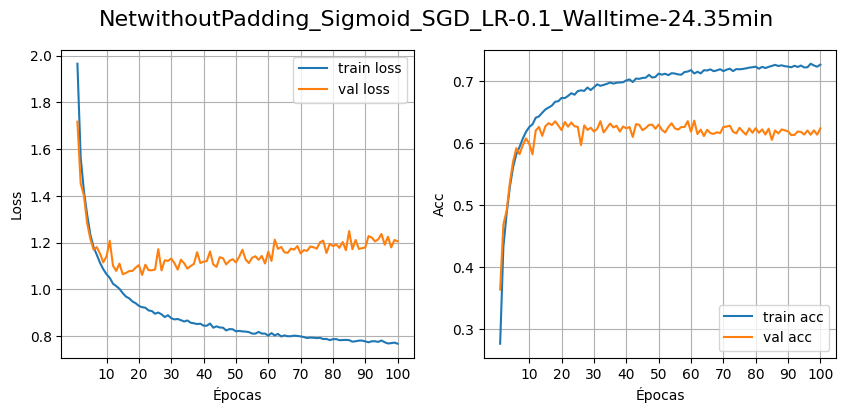

In [178]:
path = 'https://raw.githubusercontent.com/Cheva94/Diplo_Opt/cheva_dl_lab2/3_DL/Lab2/Outputs/NetwithoutPadding_Sigmoid_SGD_LR-0.1_Walltime-24.35min_Metricas.csv'
plot_loss_and_accuracy(path)

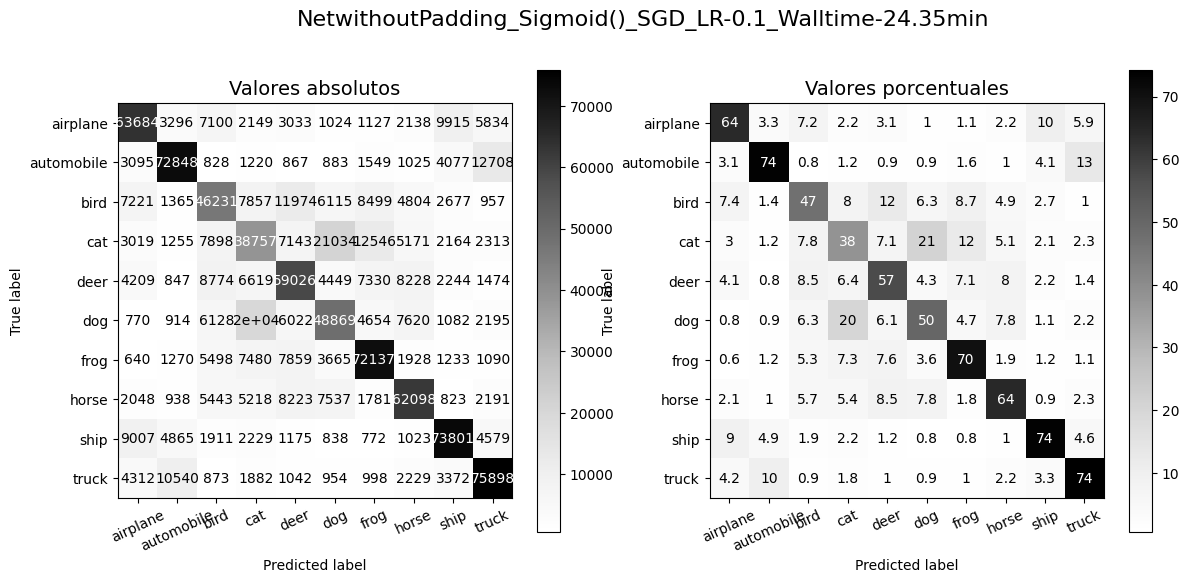

In [159]:
path = 'https://raw.githubusercontent.com/Cheva94/Diplo_Opt/cheva_dl_lab2/3_DL/Lab2/Outputs/NetwithoutPadding_Sigmoid_SGD_LR-0.1_Walltime-24.35min_Etiquetas.csv'
plotting_confusion_matrix(path, CIFAR_CLASSES)

## Estudio de la función de activación

In [162]:
# # La sigmoide es el default
# activation_functions = [nn.Tanh(), nn.ReLU(), nn.LeakyReLU()]

# for af in activation_functions:
#     model = NetwithoutPadding()
#     model.actfunc = af
#     print(model.actfunc)
#     optimizer = optim.SGD(model.parameters(), lr=1e-1, momentum=0.9)
#     train_val(model, criterion, optimizer, train_loader, val_loader, EPOCHS)

Tanh()
>>> Running...
Voy por la época 10! :)
	 Train >> Loss: 5.0218 - Acc: 0.3218
	   Val >> Loss: 4.8387 - Acc: 0.3098
Voy por la época 20! :)
	 Train >> Loss: 4.9313 - Acc: 0.3303
	   Val >> Loss: 5.3184 - Acc: 0.3301
Voy por la época 30! :)
	 Train >> Loss: 4.9604 - Acc: 0.3276
	   Val >> Loss: 4.1435 - Acc: 0.3363
Voy por la época 40! :)
	 Train >> Loss: 4.7425 - Acc: 0.3550
	   Val >> Loss: 5.1613 - Acc: 0.3342
Voy por la época 50! :)
	 Train >> Loss: 4.9806 - Acc: 0.3489
	   Val >> Loss: 4.3412 - Acc: 0.3663
Voy por la época 60! :)
	 Train >> Loss: 4.7649 - Acc: 0.3564
	   Val >> Loss: 4.6819 - Acc: 0.3463
Voy por la época 70! :)
	 Train >> Loss: 4.8114 - Acc: 0.3503
	   Val >> Loss: 4.7322 - Acc: 0.3376
Voy por la época 80! :)
	 Train >> Loss: 4.6856 - Acc: 0.3612
	   Val >> Loss: 5.9730 - Acc: 0.3700
Voy por la época 90! :)
	 Train >> Loss: 4.6566 - Acc: 0.3628
	   Val >> Loss: 4.5597 - Acc: 0.3748
	Terminé! :D
	 Train >> Loss: 4.7615 - Acc: 0.3681
	   Val >> Loss: 4.3958 - A

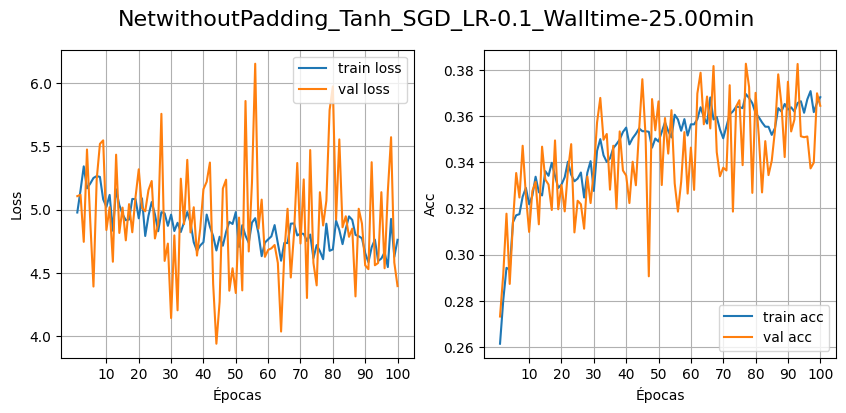

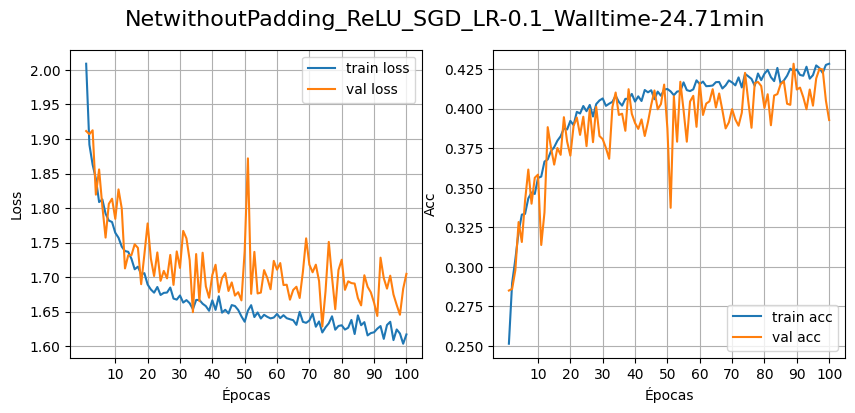

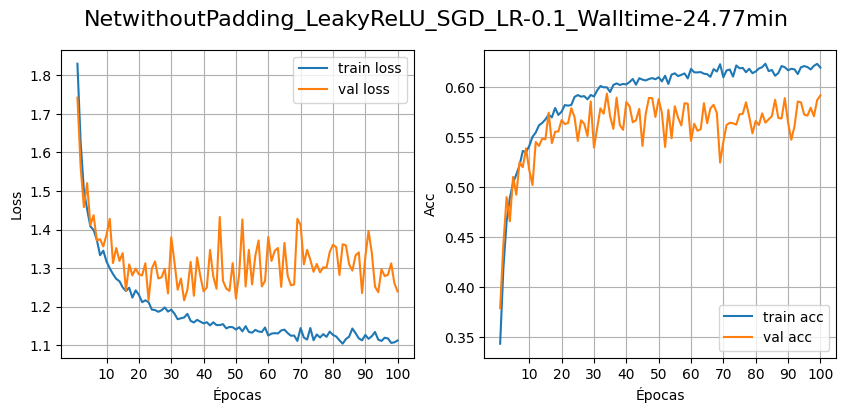

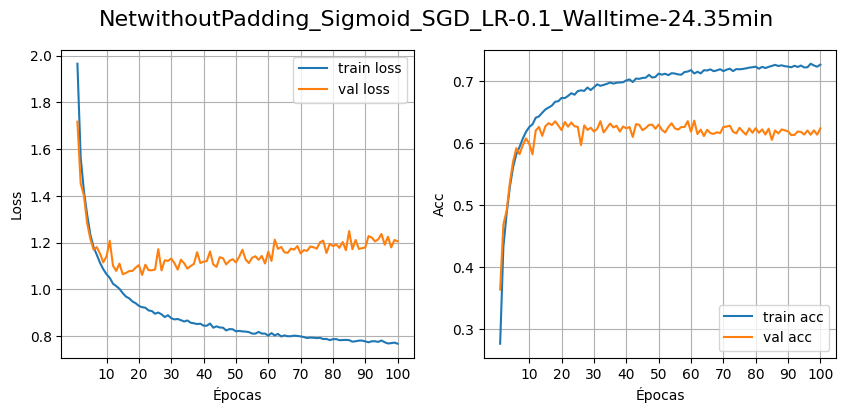

In [180]:
prefix = 'https://raw.githubusercontent.com/Cheva94/Diplo_Opt/cheva_dl_lab2/3_DL/Lab2/Outputs/NetwithoutPadding_'
for path in ['Tanh_SGD_LR-0.1_Walltime-25.00min_Metricas.csv',
            'ReLU_SGD_LR-0.1_Walltime-24.71min_Metricas.csv',
            'LeakyReLU_SGD_LR-0.1_Walltime-24.77min_Metricas.csv',
            'Sigmoid_SGD_LR-0.1_Walltime-24.35min_Metricas.csv']:
    plot_loss_and_accuracy(prefix+path)

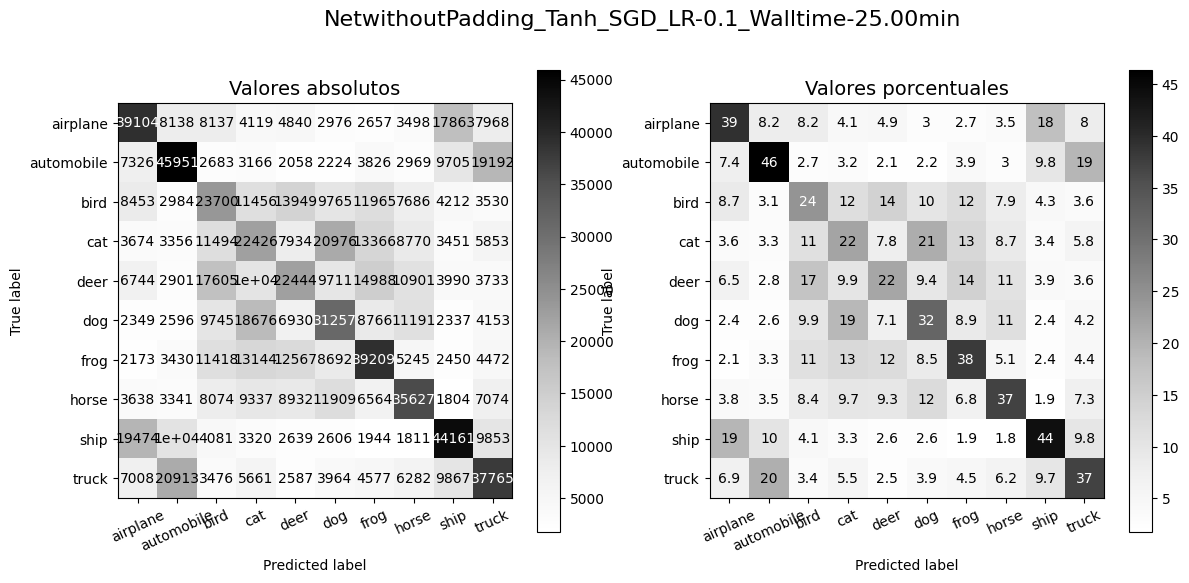

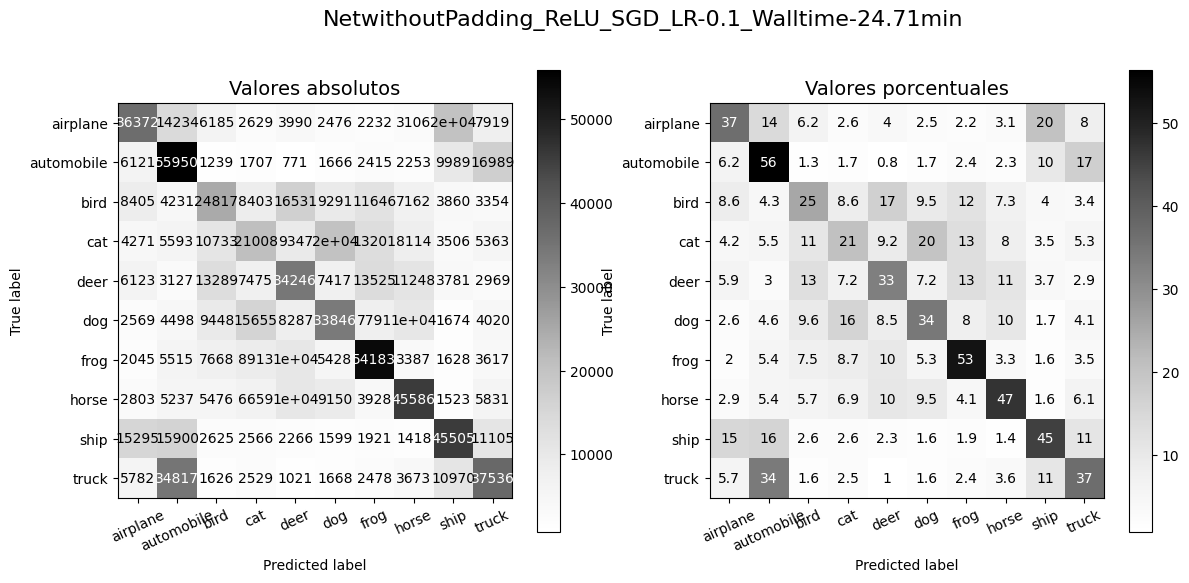

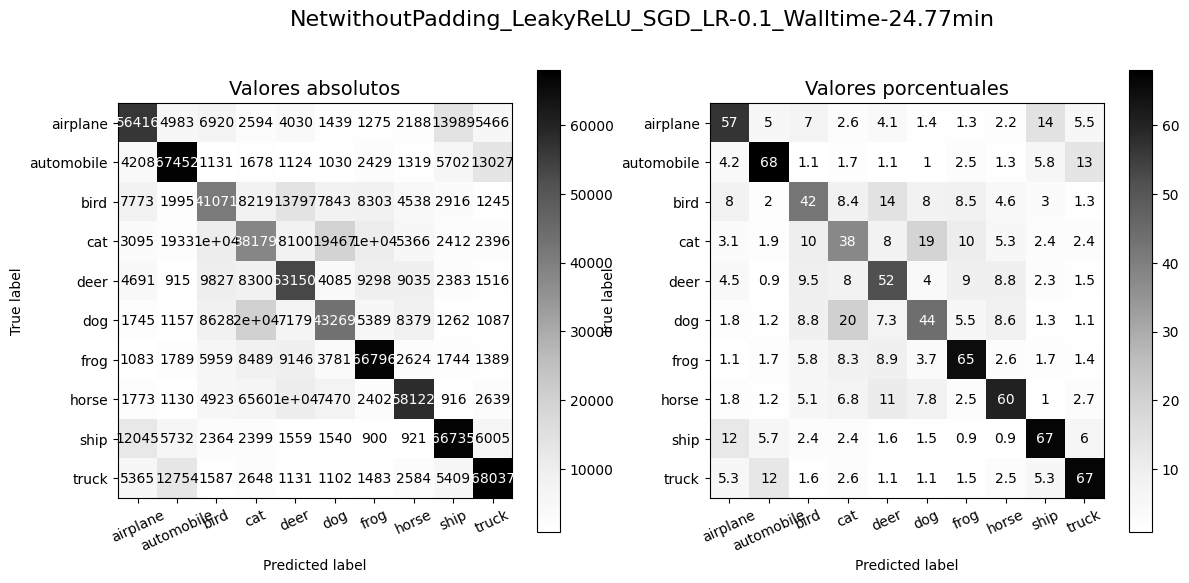

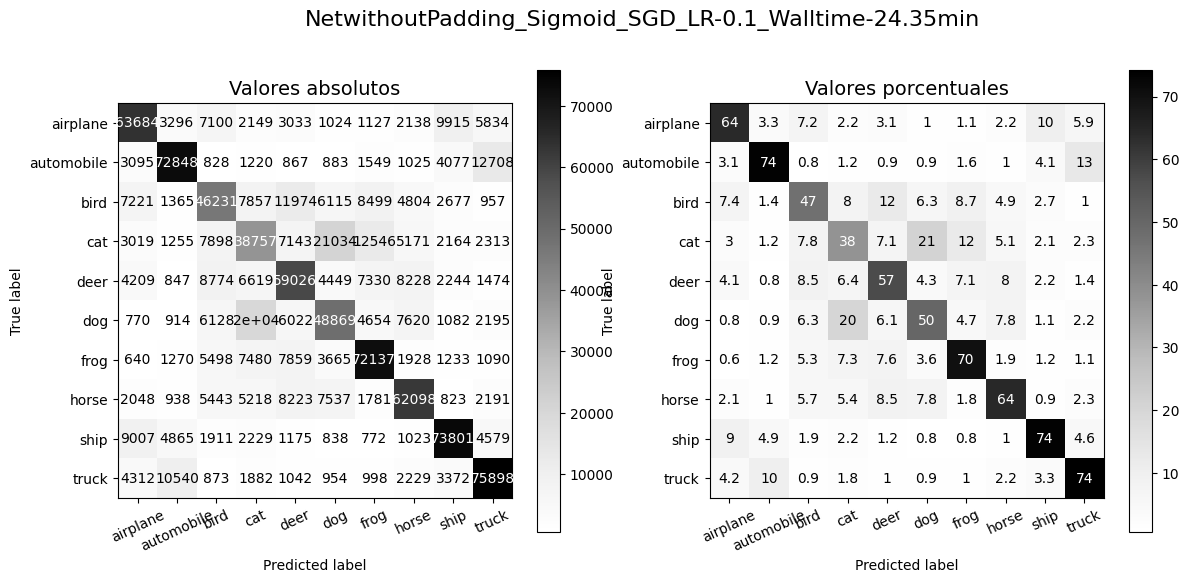

In [181]:
prefix = 'https://raw.githubusercontent.com/Cheva94/Diplo_Opt/cheva_dl_lab2/3_DL/Lab2/Outputs/NetwithoutPadding_'
for path in ['Tanh_SGD_LR-0.1_Walltime-25.00min_Etiquetas.csv',
            'ReLU_SGD_LR-0.1_Walltime-24.71min_Etiquetas.csv',
            'LeakyReLU_SGD_LR-0.1_Walltime-24.77min_Etiquetas.csv',
            'Sigmoid_SGD_LR-0.1_Walltime-24.35min_Etiquetas.csv']:
    plotting_confusion_matrix(prefix+path, CIFAR_CLASSES)

## Estudio del optimizador

In [ ]:
# SGD es el default
optimizadores = [optim.Adagrad, optim.RMSprop, optim.Adam]

for gd in optimizadores:
    print(gd)
    model = NetwithoutPadding()
    # Usamos la función de activación elegida
    model.actfunc = nn.ReLU()
    optimizer = gd(model.parameters(), lr=1e-1)
    train_val(model, criterion, optimizer, train_loader, val_loader, EPOCHS)

In [ ]:
prefix = 'https://raw.githubusercontent.com/Cheva94/Diplo_Opt/cheva_dl_lab2/3_DL/Lab2/Outputs/NetwithoutPadding_'
for path in ['ReLU_SGD_LR-0.1_Walltime-min_Metricas.csv',
            'ReLU_Adagrad_LR-0.1_Walltime-min_Metricas.csv',
            'ReLU_RMSprop_LR-0.1_Walltime-min_Metricas.csv',
            'ReLU_Adam_LR-0.1_Walltime-min_Metricas.csv']:
    plot_loss_and_accuracy(prefix+path)

In [ ]:
prefix = 'https://raw.githubusercontent.com/Cheva94/Diplo_Opt/cheva_dl_lab2/3_DL/Lab2/Outputs/NetwithoutPadding_'
for path in ['ReLU_SGD_LR-0.1_Walltime-min_Etiquetas.csv',
            'ReLU_Adagrad_LR-0.1_Walltime-min_Etiquetas.csv',
            'ReLU_RMSprop_LR-0.1_Walltime-min_Etiquetas.csv',
            'ReLU_Adam_LR-0.1_Walltime-min_Etiquetas.csv']:
    plotting_confusion_matrix(prefix+path, CIFAR_CLASSES)

## Estudio de la tasa de aprendizaje

In [ ]:
# # 0.1 es el default
# alphas = [1e-2, 1e-3, 1e-4]

# for lr in alphas:
#     print(lr)
#     model = NetwithoutPadding()
#     model.actfunc = # poner la que elegida del estudio anterior
#     optimizer = # optim.SGD(model.parameters(), lr=1e-1, momentum=0.9)
#     optimizer = # gd(model.parameters(), lr=1e-1)
#     train_val(model, criterion, optimizer, train_loader, val_loader, EPOCHS)